# Notebook2Script

In [2]:
import torch
import torchvision.transforms as T
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import kaggle
import zipfile
import shutil
import os
import json
from pathlib import Path
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Data

In [2]:
# Messy experiment codes 

```python
%%writefile helper/setup_data.py
import torchvision.transforms as T
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
import kaggle
import zipfile
import shutil
import os
import json
from pathlib import Path
```

```python
%%writefile -a helper/setup_data.py

def get_data_transforms():
    """
    Returns the data transforms for training and validation/testing.

    :return: A tuple containing two transforms.
             The first transform is for training data and
             the second transform is for validation/testing data.
    :rtype: tuple
    :raises: None
    """
    train_transforms = T.Compose([T.RandomResizedCrop(224),
                                      T.RandomRotation(35),
                                      T.RandomVerticalFlip(0.27),
                                      T.RandomHorizontalFlip(0.27),
                                      T.ToTensor(),
                                      T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    valid_n_test_transforms = T.Compose([T.Resize((224,224)),
                                       T.ToTensor(),
                                       T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    return train_transforms, valid_n_test_transforms
```

```python
%%writefile -a helper/setup_data.py

def download_and_extract_data():
    """
    Downloads the data from Kaggle and extracts it.

    :return: The path to the extracted data.
    :rtype: pathlib.Path
    :raises: None
    """
    path = Path('kmader/food41')
    data_path = Path('data')
    kaggle.api.dataset_download_cli(str(path))
    if not data_path.exists():
        os.mkdir(data_path)
        zipfile.ZipFile('food41.zip').extractall(data_path)
    return data_path

def setup_folder():
    """
    Downloads and extracts the data, and sets up the folder structure
    for training and validation/testing.

    :return: The path to the extracted data.
    :rtype: pathlib.Path
    :raises: None
    """
    data_path = download_and_extract_data()
    if os.path.exists('data/train'):
        return data_path
    
    with open(data_path/'meta/meta/train.json', 'r') as fp:
        train_dict = json.load(fp)
    with open(data_path/'meta/meta/test.json', 'r') as fp:
        test_dict = json.load(fp)

    new_folders = ['train', 'test']
    for folder in new_folders:
        if not os.path.exists(data_path/folder):
            os.mkdir(data_path/folder)
        if folder == 'train':
            if not os.path.exists(data_path/'valid'):
                os.mkdir(data_path/'valid')
            for key, value in train_dict.items():
                train_value, valid_value = train_test_split(value, train_size=0.75)
                train_set, valid_set = set(train_value), set(valid_value)
                if not os.path.exists(data_path/folder/key):
                    os.mkdir(data_path/folder/key)
                if not os.path.exists(data_path/'valid'/key):
                    os.mkdir(data_path/'valid'/key)
                for image in os.listdir(data_path/'images'/key):
                    image_path = key + '/' + image
                    image_id = image_path.split('.')[0]
                    if image_id in train_set:
                        shutil.move(data_path/'images'/image_path, data_path/folder/image_path)
                    if image_id in valid_set:
                        shutil.copy(data_path/'images'/image_path, data_path/'valid'/image_path)
        else:
            for key, value in test_dict.items():
                test_set = set(value)
                if not os.path.exists(data_path/folder/key):
                    os.mkdir(data_path/folder/key)
                for image in os.listdir(data_path/'images'/key):
                    image_path = key + '/' + image
                    image_id = image_path.split('.')[0]
                    if image_id in test_set:
                        shutil.move(data_path/'images'/image_path, data_path/folder/image_path)
    shutil.rmtree(data_path/'images')
    return data_path

def get_data_loaders(batch_size=64):
    """
    Returns the data loaders for training, validation, and testing.

    :param batch_size: The batch size for the data loaders.
    :type batch_size: int
    :return: A tuple containing three data loaders.
             The first data loader is for training data,
             the second data loader is for validation data,
             and the third data loader is for testing data. 
             Each data loader is an instance of the `torch.utils.data.DataLoader` class.
    :rtype: tuple
    :raises: None
    """
    data_path = setup_folder()
    train_transforms, valid_n_test_transforms = get_data_transforms()

    train_data = datasets.ImageFolder(str(data_path/'train'), transform=train_transforms)
    valid_data = datasets.ImageFolder(str(data_path/'valid'), transform=valid_n_test_transforms)
    test_data = datasets.ImageFolder(str(data_path/'test'), transform=valid_n_test_transforms)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    return train_loader, valid_loader, test_loader, test_data
```

```python
%%writefile -a helper/setup_data.py

def get_metadata(dataset):
    """
    Returns the metadata for the dataset.

    :param dataset: The dataset.
    :type dataset: torch.utils.data.Dataset
    :return: A tuple containing three items.
             The first item is a list of class names.
             The second item is a dictionary mapping class names to indices.
             The third item is a dictionary mapping indices to class names.
    :rtype: tuple
    :raises: None
    """
    classess, class_to_idx = dataset.classes, dataset.class_to_idx
    idx_to_class = {value: key for key, value in class_to_idx.items()}
    return classess, class_to_idx, idx_to_class
```

In [3]:
from helper.setup_data import get_data_loaders, get_metadata

In [4]:
train_loader, valid_loader, test_loader, test_data = get_data_loaders(64)

food41.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
classess, class_to_idx, idx_to_class = get_metadata(test_data)
print('classess: ', classess)
print('class_to_idx: ', class_to_idx)
print('idx_to_class: ', idx_to_class)

classess:  ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons'

In [6]:
x, y = next(iter(train_loader))

In [7]:
print(x.shape)
print(y.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


## Plotting

```python
%%writefile helper/plot.py
import torch
import matplotlib.pyplot as plt
```

```python
%%writefile -a helper/plot.py

def imshow(image, ax=None, title=None):
    """
    imshow for IMAGENET-style transformed images in
    torch.Tensor format.

    :param image: The image to be plotted.
    :type image: torch.Tensor
    :param ax: The axis to plot the image on.
    :type ax: matplotlib.axes.Axes
    :param title: The title of the plot.
    :type title: str
    :return: The axis with the plotted image.
    :rtype: matplotlib.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.permute((1, 2, 0))
    
    # Undo preprocessing
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    image = (std * image + mean)
    
    
    ax.imshow(image)
    if title is not None:
        ax.set_title(title)
    
    return ax
```

```python
%%writefile -a helper/plot.py

def image_grid(images, labels, idx_to_class, rows=2, cols=4, figsize=(20, 10)):
    """
    Plots a grid of images and their labels.

    :param images: The images to be plotted.
    :type images: torch.Tensor
    :param labels: The labels of the images.
    :type labels: torch.Tensor
    :param class_to_idx: A dictionary mapping class names to indices.
    :type class_to_idx: dict
    :param idx_to_class: A dictionary mapping indices to class names.
    :type idx_to_class: dict
    :param rows: The number of rows in the grid.
    :type rows: int
    :param cols: The number of columns in the grid.
    :type cols: int
    :param figsize: The size of the figure.
    :type figsize: tuple
    :return: None
    :rtype: None
    """
    _, axes = plt.subplots(rows, cols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        ax = imshow(images[i], ax=ax, title=idx_to_class[labels[i].item()])
    plt.tight_layout()
    plt.show()
```

In [14]:
from helper.plot import *

In [15]:
y[0]

tensor(26)

<Axes: title={'center': 'crab_cakes'}>

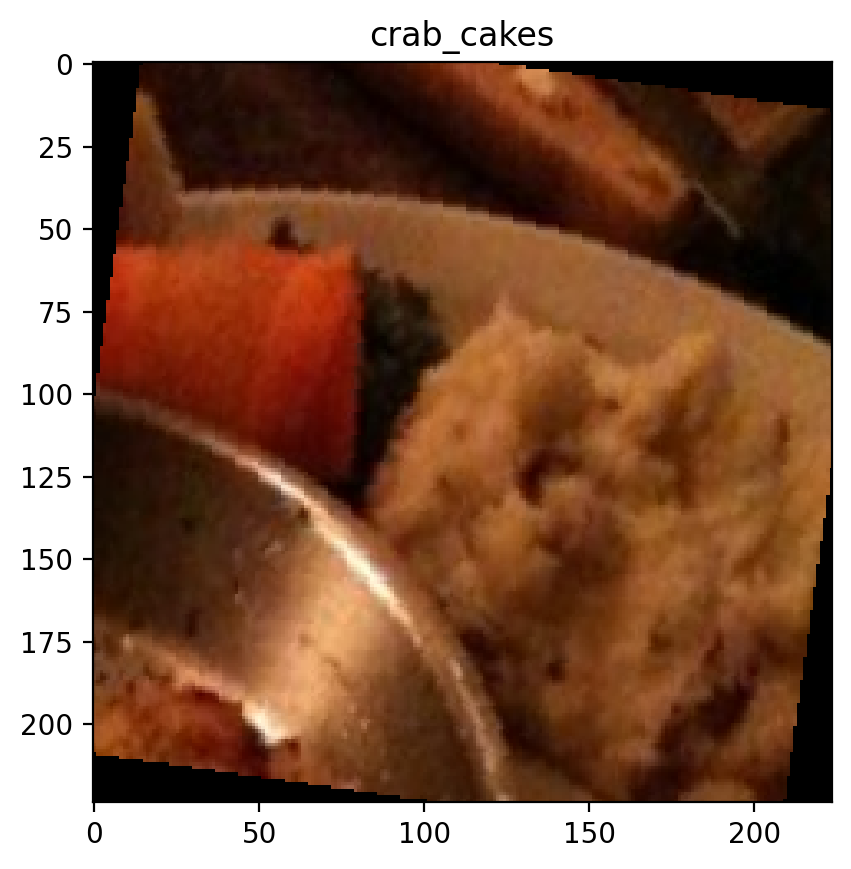

In [16]:
imshow(x[0], title=f'{idx_to_class.get(int(y[0]), "Unknown")}')

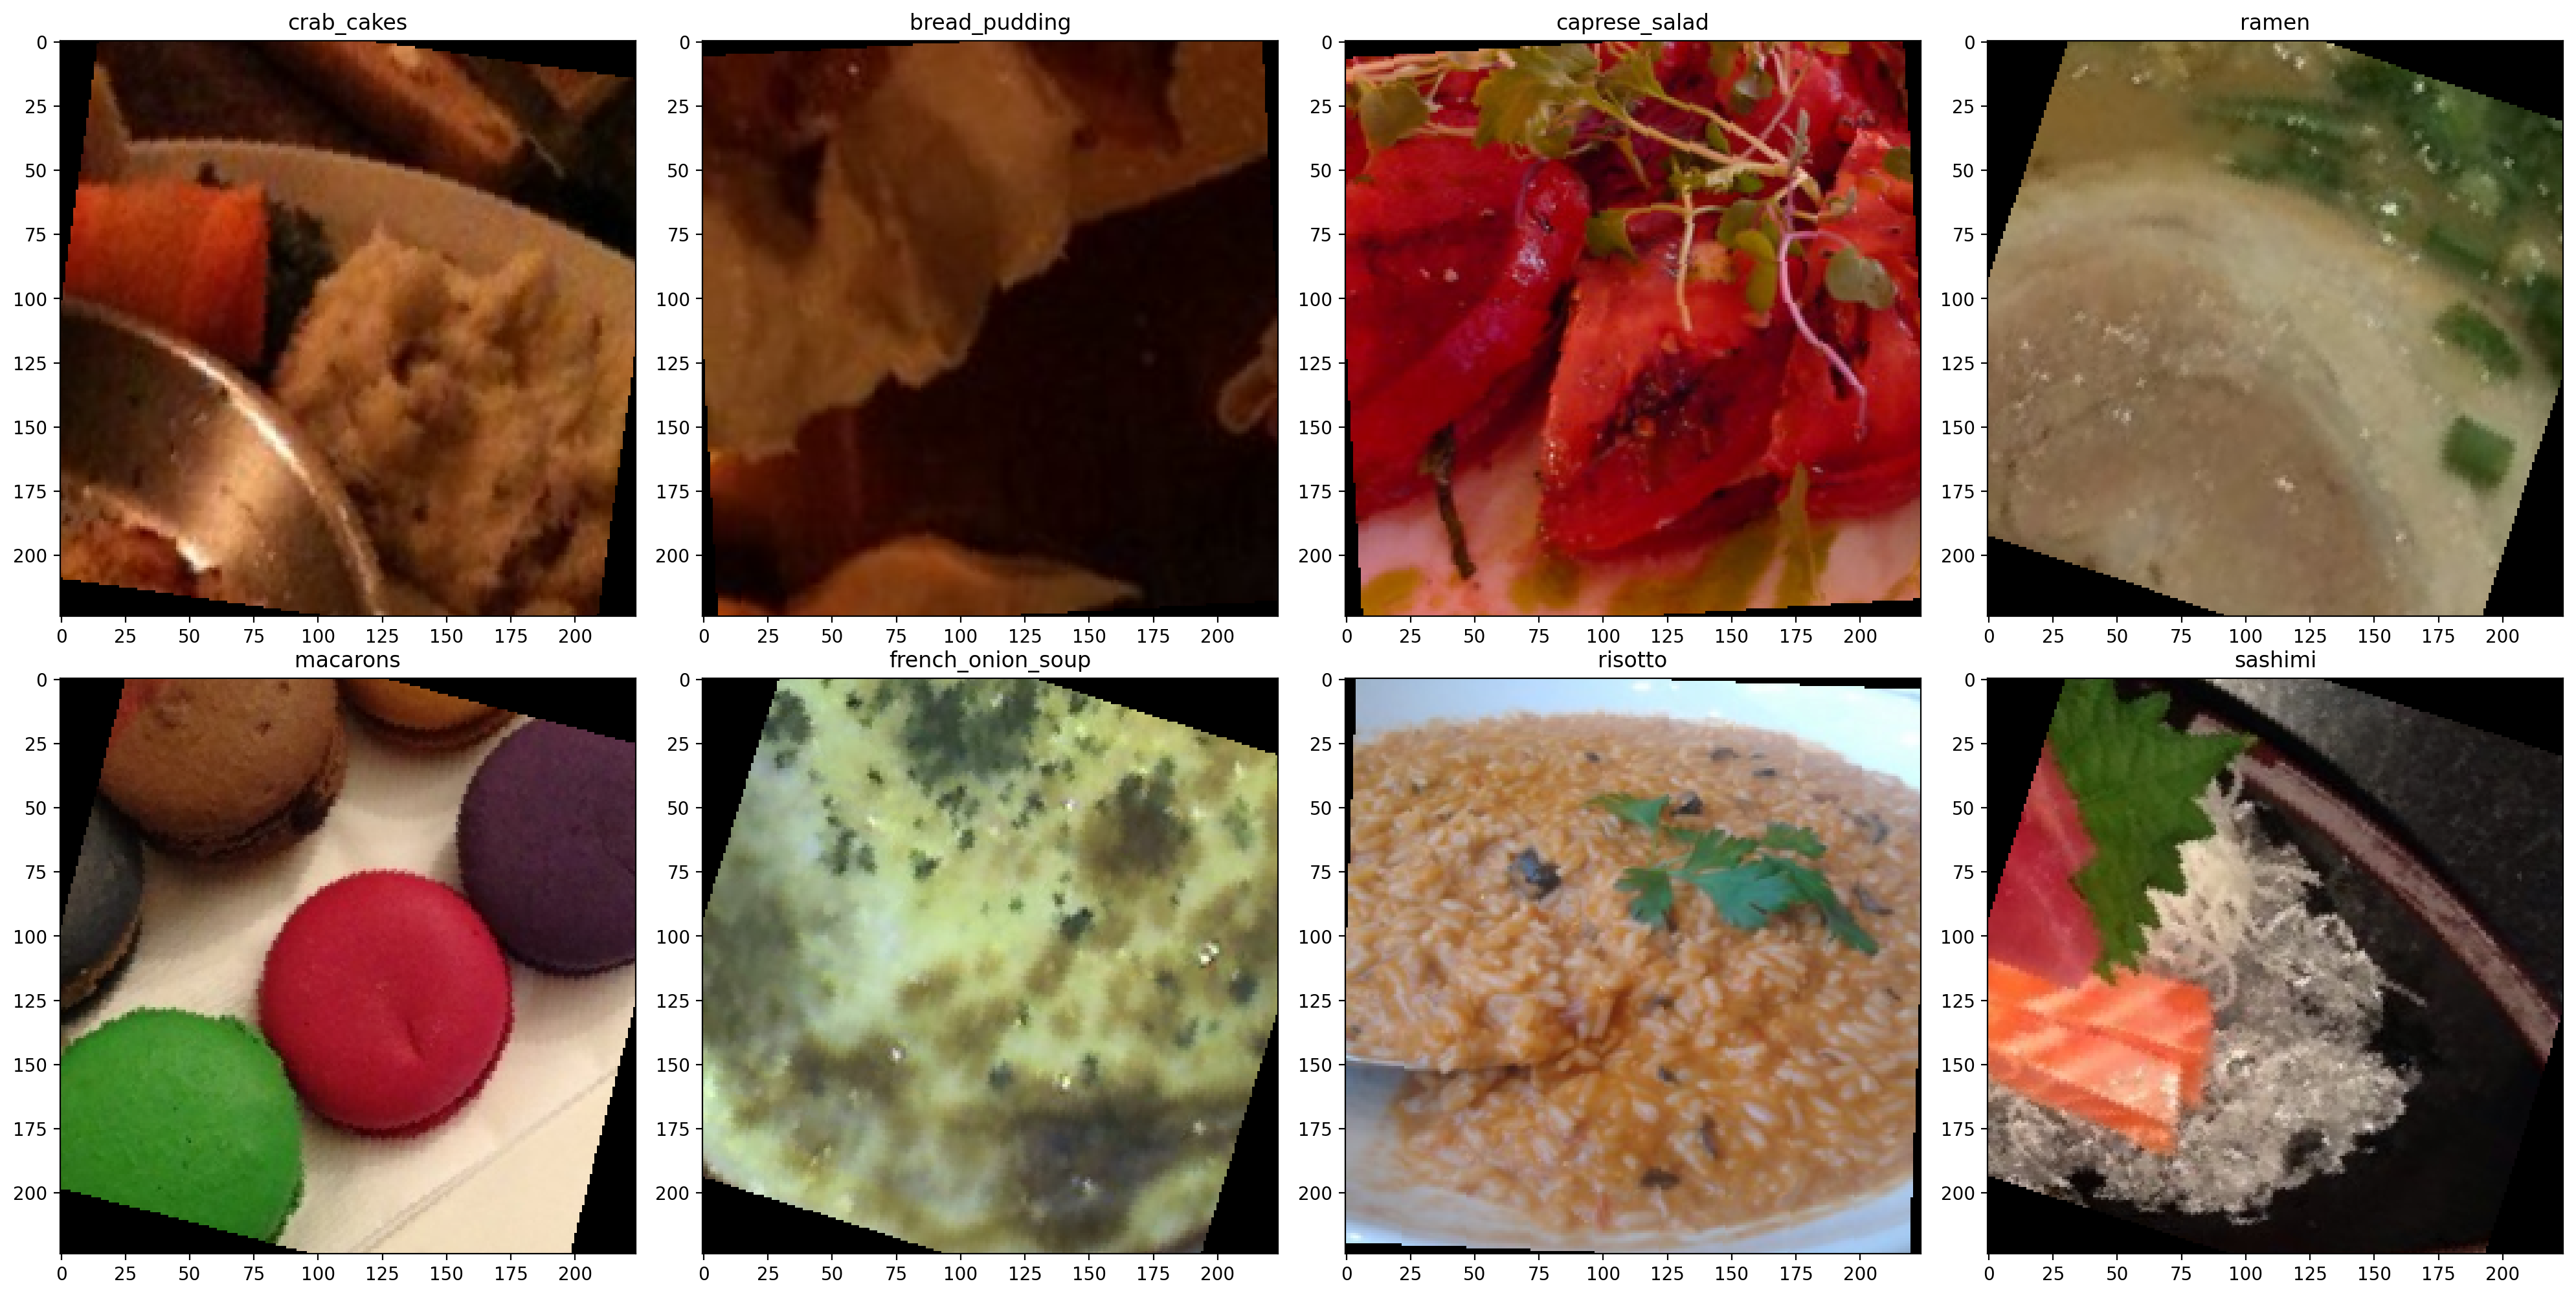

In [17]:
image_grid(x, y, idx_to_class)